<a href="https://www.kaggle.com/code/kavishchaudhary1003/covid-19-data-classification-multiple-models?scriptVersionId=120397757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import category_encoders as ce
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, IsolationForest, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold


import os
for dirname, _, filenames in os.walk('/kaggle/input/covid19-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-dataset/Covid Data.csv


In [2]:
df = pd.read_csv('/kaggle/input/covid19-dataset/Covid Data.csv')

#### Printing the value counts for the train set

In [3]:
for i in ('USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'ICU'):
    print(df[i].value_counts())

2    662903
1    385672
Name: USMER, dtype: int64
12    602995
4     314405
6      40584
9      38116
3      19175
8      10399
10      7873
5       7244
11      5577
13       996
7        891
2        169
1        151
Name: MEDICAL_UNIT, dtype: int64
1    525064
2    523511
Name: SEX, dtype: int64
1    848544
2    200031
Name: PATIENT_TYPE, dtype: int64
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: DATE_DIED, Length: 401, dtype: int64
97    848544
2     159050
1      33656
99      7325
Name: INTUBED, dtype: int64
2     892534
1     140038
99     16003
Name: PNEUMONIA, dtype: int64
30     27010
31     25927
28     25313
29     25134
34     24872
       ...  
114        2
116        2
111        1
121        1
113        1
Name: AGE, Length: 121, dtype: int64
97    523511
2     513179
1       8131
9

#### Replacing the null values and recoding them.
#### 97,98 and 99 are coded as null values.
#### 999-99-99 is coded as null value. Converting it into a categorical variable. 1 is for death and 2 is for no death.
#### Separating the predictors and traget variable.

In [4]:
df['INTUBED'] = np.where(df['INTUBED'] == 97,2, df['INTUBED'])
df['INTUBED'] = np.where(df['INTUBED'] == 99,1, df['INTUBED'])        
df['ICU'] = np.where(df['ICU'] == 97,2, df['ICU'])
df['ICU'] = np.where(df['ICU'] == 99,1, df['ICU'])    
df['PREGNANT'] = np.where(df['PREGNANT'] == 97, 2, df['PREGNANT'])
df['PREGNANT'] = np.where(df['PREGNANT'] == 98, 1, df['PREGNANT'])
df['PNEUMONIA'] = np.where(df['PNEUMONIA'] == 99,2,df['PNEUMONIA'])
for i in('DIABETES','COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO'):         
    df[i] =  np.where(df[i]== 98, 2, df[i])




df['DEATH'] = [2 if row=='9999-99-99' else 1 for row in df['DATE_DIED']]
y = df.DEATH
df =  df.drop(columns = ['DEATH', 'DATE_DIED']) 

#### Checking the distribution of the target variable

<AxesSubplot:xlabel='DEATH', ylabel='count'>

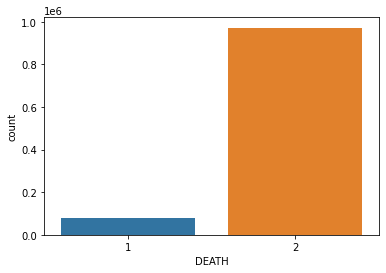

In [5]:
sns.countplot(x= y)


#### Checking the distribution of the categorical predcitor variables.

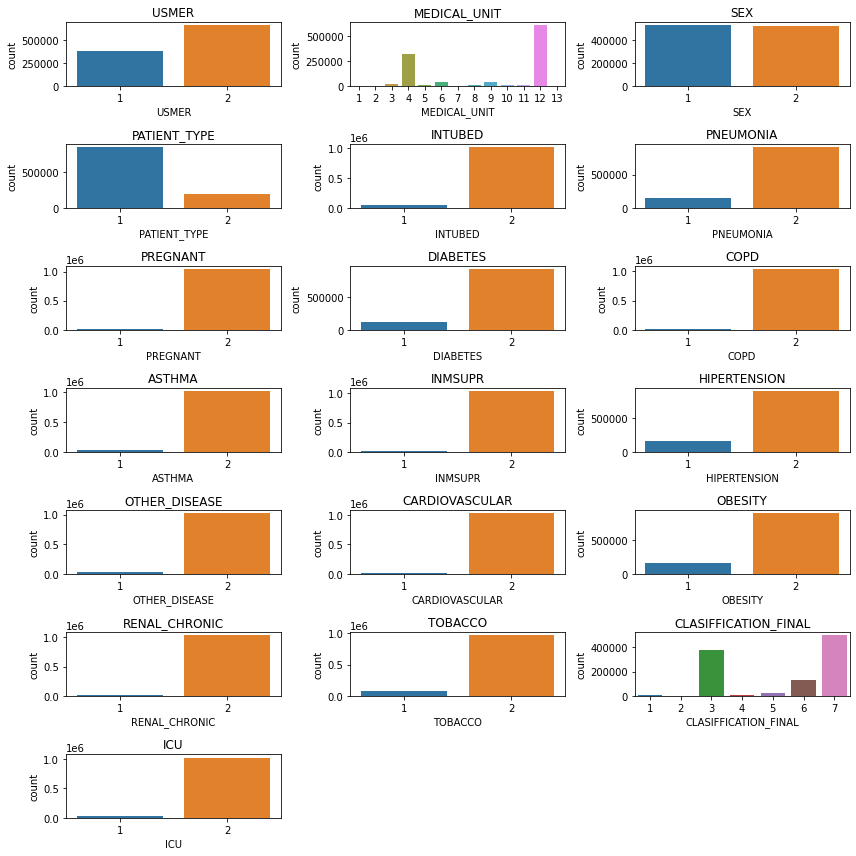

In [6]:
fig, axes = plt.subplots(nrows=7, ncols = 3, figsize=(12,12))
for i, ax in enumerate(axes.flat):
    if i< len(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU']):
        sns.countplot(x= df[(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'][i])], ax= ax)
        ax.set_title(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()


#### Checking the distribution of the continuous predictor variable.

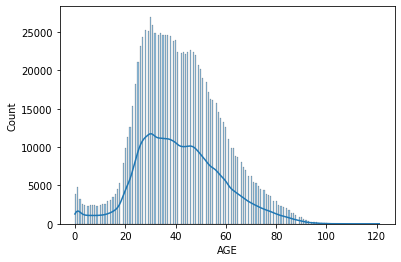

In [7]:
sns.histplot(x= df.AGE, kde = True)
plt.show()

### one hot encoding

In [8]:
df_final = pd.get_dummies(df, columns = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'ICU'])

#### Defining a function model_eval which uses RandomizedSearchCV for parameter tuning 
* Nested cross val used for training and testing to reduce the bias.
* tqdm used to display a progress bar when performing parameter tuning.
* Storing the score during each iteration and printing the mean score. 

In [ ]:
def model_eval(model, param, df_final, y):
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    random = RandomizedSearchCV(model, param, scoring = 'accuracy', n_jobs = -1, cv = inner_cv, random_state = 0, n_iter =1)
    scores = []
    n_iter = random.n_iter
    with tqdm(total = n_iter) as pbar:
        for i in range(n_iter):
            random.set_params(n_iter = 1)
            for train_index, test_index in outer_cv.split(df_final, y):
                trainx, testx = df_final.iloc[train_index], df_final.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                random.fit(trainx, trainy)
                scores.append(random.best_estimator_.score(testx, testy))
            pbar.update()
    print(random.best_params_)
    print('Average score', np.mean(scores))

### Decision Tree used for predictions
Mean accuracy of 94.8% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier

In [ ]:
model = DecisionTreeClassifier()
min_samples_split = np.array(range(1, 100))
max_depth= np.array(range(1,100))
criterion = ['entropy', 'gini', 'log_loss']
param = {'min_samples_split': min_samples_split, 'max_depth' : max_depth, 'criterion' : criterion}
model_eval(model, param, df_final, y)

### Random Forest used for predcitions
Mean accuracy of 95.11% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier
* n_estimators- no. of trees in the forest

In [ ]:
model = RandomForestClassifier()
min_samples_split = np.array(range(1, 100))
max_depth = np.array(range(1, 100))
criterion = ['gini', 'entropy']
n_estimators = np.array(range(100, 400, 5))
param = {'min_samples_split': min_samples_split, 'max_depth': max_depth, 'criterion': criterion, 'n_estimators': n_estimators}
model_eval(model, param, df_final, y)

### Extra Trees used for predcitions
Mean accuracy of 95.07% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier
* n_estimators- no. of trees in the forest

In [ ]:
model = ExtraTreesClassifier()
criterion = ['gini', 'entropy']
max_depth = np.array(range(50, 150))
min_samples_split = np.array(range(1, 100))
n_estimators = np.array(range(100,300, 2))
param = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'n_estimators': n_estimators}
model_eval(model, param, df_final, y)

### GaussianNB used for prediction
Mean accuracy of 90.9% obtained in the test set.

Parameters tuned:
* var_smoothing- Adds a value to the variance of the distribution of the train set

In [ ]:
model = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9, num=100)}
model_eval(model, param, df_final, y)